# Plot Setting

The generated images below may slightly differ from those in the paper, but this does not impact our main conclusions. The discrepancy is primarily due to differences in the sorting of items with the same count by the value_counts function.

In [ ]:
import os
import sys
from pathlib import Path

# Set root and data directories
ROOT_DIR = Path(os.getcwd()).resolve().parent.parent
sys.path.insert(0, str(ROOT_DIR))
from path import DATA_DIR

print("ROOT_DIR:", ROOT_DIR)
print("DATA_DIR:", DATA_DIR)

# Set plot directory
os.chdir(DATA_DIR / f"result_2025/down_stream_analysis")



ROOT_DIR: /data/sequential_data/results
DATA_DIR: /data/sequential_data


In [10]:
import pickle
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use("Agg")

mpl.rcParams.update({
    "axes.labelsize": 7,
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "legend.frameon": False,
    "legend.fontsize": 3,
    "axes.linewidth": 0.5,
    "pdf.fonttype": 42,
    "figure.dpi": 300,
})
%matplotlib inline


## 1. Read and processes pathway data
pathway data for multiple cell lines and computes statistics for the top 10 most frequent pathways in each class. 

In [11]:
# 1. Data preparation

all_ccls = ["A375", 'MDAMB231', 'SKBR3', 'MCF7', 'HS578T', 'BT20', 'HEPG2', 'HUH7', 'HCC515', 'A549']
all_res = []

for cell_line in all_ccls:
    # Load pathway data
    key_pathway_file_name = f"key_pathway_res/{cell_line}.pkl"
    with open(key_pathway_file_name, "rb") as f:
        key_pathway_ls = pickle.load(f)

    # Load cluster labels
    with open(f"cluster_label_res/{cell_line}.pkl", "rb") as f:
        cluster_label_ls, _ = pickle.load(f)

    # Replace empty lists with empty DataFrame
    key_pathway_arr = np.array(key_pathway_ls, dtype=object)
    null_df = next((item for item in key_pathway_arr if isinstance(item, pd.DataFrame) and item.shape[0] == 0), None)
    new_key_pathway_arr = [null_df if isinstance(item, list) else item for item in key_pathway_arr]
    key_pathway_arr = np.array(new_key_pathway_arr, dtype=object)

    # Count pathway frequencies and sort by count
    pathways, cnts = np.unique(pd.concat(key_pathway_arr).index, return_counts=True)
    pathway_stats = pd.DataFrame({"pathway": pathways, "count": cnts}).sort_values("count", ascending=False)
    
    # Select top N pathways
    N = 10
    pathway_stats = pathway_stats.iloc[:N, :]
    pathway_stats["cell_line"] = [cell_line] * N
    pathway_stats["freq"] = pathway_stats["count"] * 100 / len(key_pathway_ls)
    pathway_stats["rank"] = np.arange(N, 0, -1)
    
    # Append to the results list
    all_res.append(pathway_stats)

# Concatenate all results
all_res = pd.concat(all_res)


/tmp/ipykernel_637493/3915634736.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathways, cnts = np.unique(pd.concat(key_pathway_arr).index, return_counts=True)
/tmp/ipykernel_637493/3915634736.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathways, cnts = np.unique(pd.concat(key_pathway_arr).index, return_counts=True)
/tmp/ipykernel_637493/3915634736.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this w

## 2. Create plot data

In [12]:
import re

def process_string(input_str, len_thre=20):
    if len(input_str) <= len_thre:
        return input_str

    words = re.findall(r'\S+', input_str)
    result, line, length = [], [], 0

    for word in words:
        if length + len(word) <= len_thre:
            line.append(word)
            length += len(word) + 1
        else:
            result.append(" ".join(line))
            line, length = [word], len(word) + 1

    if line:
        result.append(" ".join(line))

    return "\n".join(result)


In [13]:
# Get the top N pathways (unique pathways in all_res)
top_n = len(np.unique(all_res["pathway"]))
pathway_keys = list(all_res.value_counts("pathway").index[:top_n])
pathway_vals = all_res.value_counts("pathway").values[:top_n]

# Create pathway and class mapping dictionaries
pathway_dict = {key: value for key, value in zip(pathway_keys, range(top_n, 0, -1))}
ccl_dict = {key: value for key, value in zip(all_ccls, range(1, len(all_ccls) + 1))}

# Process pathway names for visualization
pathway_names = [process_string(p) for p in pathway_keys]

# Initialize arrays for scatter plot data
x_arr, y_arr, val_arr, color_arr, pair_arr = [], [], [], [], []

# Fill arrays with data for scatter plot
for i in range(all_res.shape[0]):
    pathway, class_label = all_res.iloc[i, 0], all_res.iloc[i, 2]
    if pathway in pathway_dict:
        x_arr.append(ccl_dict[class_label])
        y_arr.append(pathway_dict[pathway])
        pair_arr.append((ccl_dict[class_label], pathway_dict[pathway]))
        val_arr.append(all_res.iloc[i, 3])  # Frequency or size of the point
        color_arr.append(all_res.iloc[i, -1])  # Color information

# Normalize val_arr for scatter plot size
val_arr_norm = list(val_arr / np.max(val_arr))

## 3. Plot

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(6, 8), gridspec_kw={'width_ratios': [2, 1.5, 1]})

# ======= 1. Scatter Plot (Bubble Heatmap) =======
scatter = axes[0].scatter(
    x_arr, y_arr, alpha=0.5, sizes=np.array(val_arr_norm) * 90, 
    edgecolors="#323232", linewidths=0.5, c=color_arr, cmap="Reds"
)

# X-axis settings (Cell lines)
axes[0].set_xticks(np.arange(1, len(all_ccls) + 1))
axes[0].set_xticklabels(all_ccls, rotation=45, ha='right')
axes[0].tick_params(axis='x', direction='out', length=1)

# Y-axis settings (Pathways)
axes[0].set_ylim([0.5, top_n + 0.8])
axes[0].set_yticks(np.arange(1, top_n + 1))
axes[0].yaxis.tick_right()
axes[0].set_yticklabels([" "] * top_n)
axes[0].tick_params(axis='y', direction='out', length=1)

# Plot title
axes[0].set_title("Pathway-associated tumor state transitions", fontsize=7)

# Add grid lines
for i in range(1, len(all_ccls) + 1):
    axes[0].axvline(x=i, color='grey', linestyle='-', linewidth=0.5, alpha=0.2)
for i in range(top_n + 1):
    axes[0].axhline(y=i, color='grey', linestyle='-', linewidth=0.5, alpha=0.2)

# ======= 2. Color and Size Legends =======
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].get_xaxis().set_visible(False)

# Add colorbar
cax = fig.add_axes([1, 0.5, 0.02, 0.2])
cbar = plt.colorbar(scatter, ax=axes[0], cax=cax)
cbar.set_label('color_arr')

# Add size legend
legend_sizes = [90, 60, 30, 6]
legend_labels = ['15', '10', '5', '1']
scatter_legend = [
    axes[1].scatter([], [], s=size, label=label, edgecolors="#323232", linewidths=0.5, color='black')
    for size, label in zip(legend_sizes, legend_labels)
]
axes[1].legend(handles=scatter_legend, title='', bbox_to_anchor=(2.35, 1.05), loc='best')

# ======= 3. Horizontal Bar Chart (Pathway Count) =======
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].barh(np.arange(top_n, 0, -1), pathway_vals, align="center", color='#ED8072')

# Y-axis settings
axes[1].set_ylim([0.5, top_n + 0.8])
axes[1].set_yticks(np.arange(1, top_n + 1))
axes[1].set_yticklabels(pathway_keys[::-1], ha="left")
axes[1].tick_params(axis='y', direction='out', length=0)

# X and Y axis settings for bar chart
axes[2].set_ylim([0.5, top_n + 0.8])
axes[2].set_yticks(np.arange(1, top_n + 1))
axes[2].set_yticklabels([" "] * top_n)
axes[2].tick_params(axis='y', direction='out', length=1)
axes[2].tick_params(axis='x', direction='out', length=1)
axes[2].set_title("Count", fontsize=7)

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.1)
# plt.savefig(fig_name, dpi=300, bbox_inches='tight')  # Uncomment to save figure


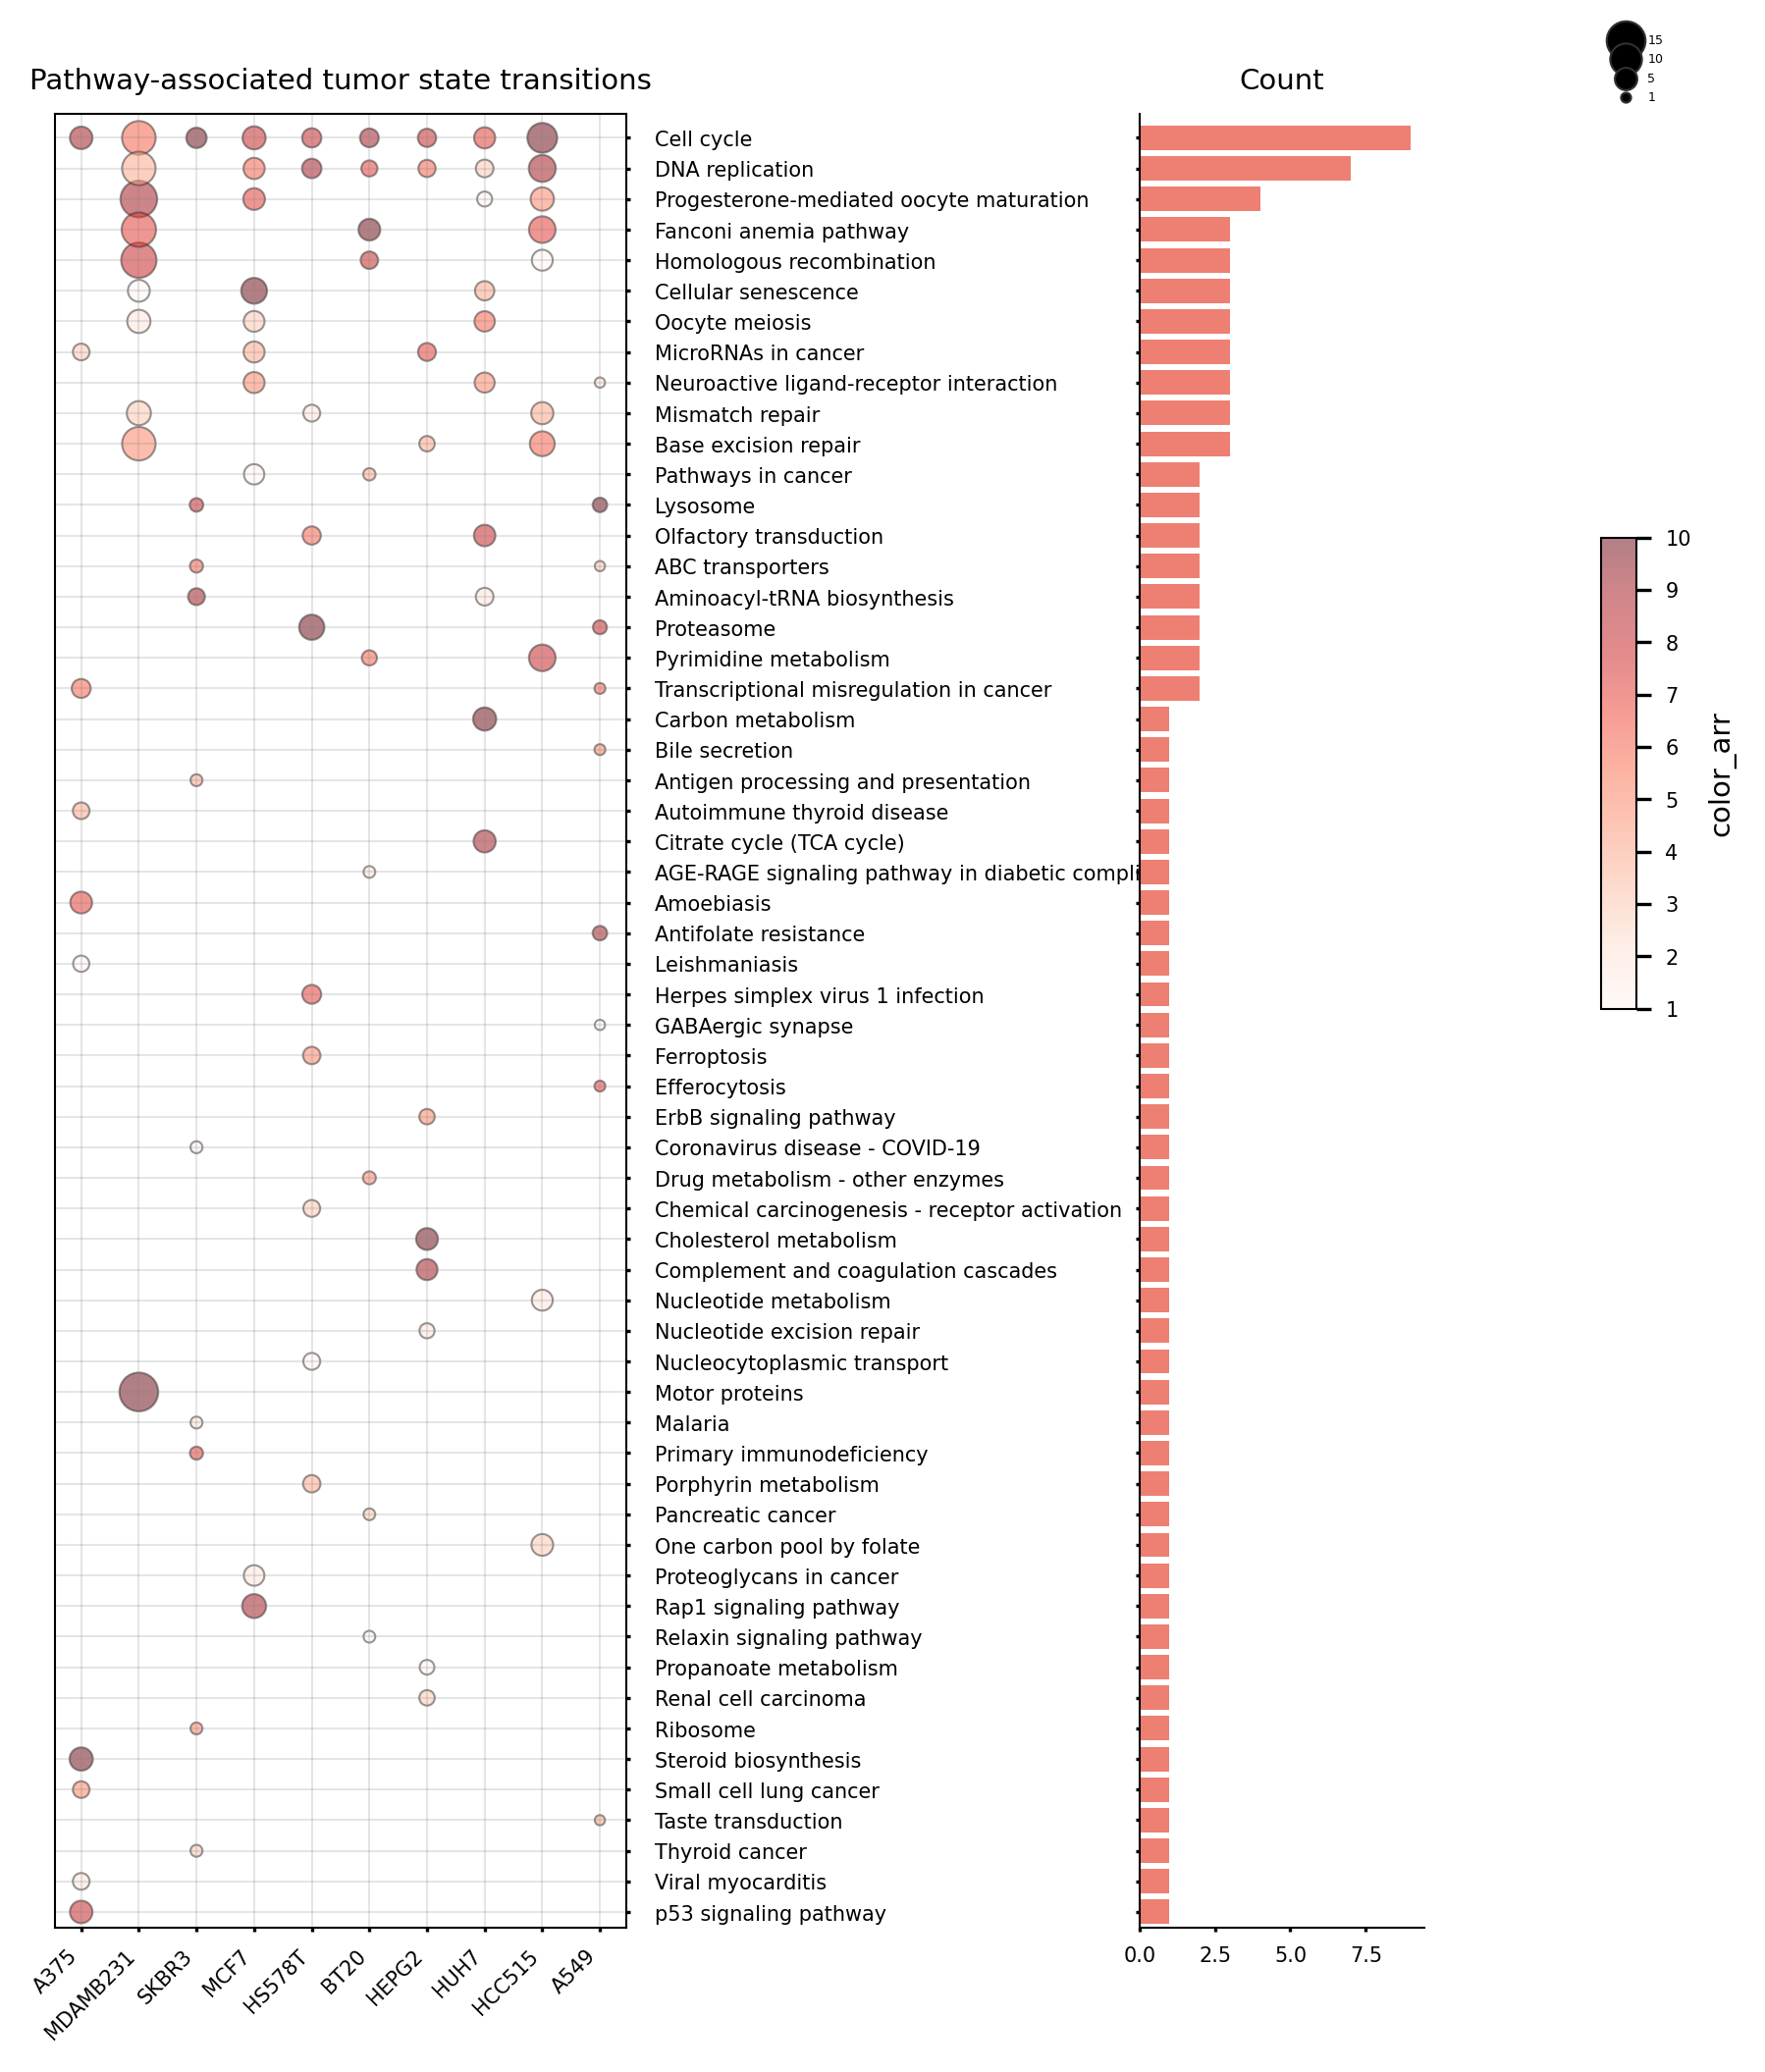

In [15]:
plt.show()